In [1]:
import os
import re
import time
import datetime
import operator
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import word2vec
from wordcloud import WordCloud, STOPWORDS
from sklearn.utils import class_weight as cw
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Conv1D, Conv2D, Convolution1D, MaxPooling1D, SeparableConv1D, SpatialDropout1D 
from keras.layers import Input, Add, concatenate, Dense, Activation, BatchNormalization, Dropout, Flatten
from keras.layers import LeakyReLU, PReLU, Lambda, Multiply
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import GlobalAvgPool1D, GlobalMaxPool1D, GlobalMaxPooling1D
from keras.layers import Embedding, LSTM, Bidirectional
from keras.layers.pooling import _GlobalPooling1D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
%matplotlib inline

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### read data

In [2]:
tweet= pd.read_csv("data/Tweets.csv")
tweet[['tweet_id','text', 'airline_sentiment', 'airline_sentiment_confidence', 'airline']].head()

,tweet_id,text,airline_sentiment,airline_sentiment_confidence,airline
0,570306133677760513,@VirginAmerica What @dhepburn said.,neutral,1.0000,Virgin America
1,570301130888122368,@VirginAmerica plus you've added commercials t...,positive,0.3486,Virgin America
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,neutral,0.6837,Virgin America
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,negative,1.0000,Virgin America
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,negative,1.0000,Virgin America


In [3]:
tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
tweet.shape

(14640, 15)

### data preprocessing

In [5]:
start_time = time.time()
#remove words which are starts with @ symbols
tweet['text'] = tweet['text'].map(lambda x:re.sub('@\w*','',str(x)))
#remove link starts with https
tweet['text'] = tweet['text'].map(lambda x:re.sub('http.*','',str(x)))
#remove special characters except [a-zA-Z]
tweet['text'] = tweet['text'].map(lambda x:re.sub('[^a-zA-Z]',' ',str(x)))
#lowercase
tweet['text'] = tweet['text'].map(lambda x:str(x).lower())
#Remove stopwords from comments
corpus = []
none=tweet['text'].map(lambda x:corpus.append(' '.join([word for word in str(x).strip().split() \
                                                        if not word in set(stopwords.words('english'))])))  
end_time = time.time()
#total time consume to filter data
print(end_time-start_time)

47.861451149


In [6]:
corpus[:5]

['said',
 'plus added commercials experience tacky',
 'today must mean need take another trip',
 'really aggressive blast obnoxious entertainment guests faces amp little recourse',
 'really big bad thing']

In [7]:
tweet['cleaned_text'] = pd.DataFrame(data=corpus,columns=['cleaned_text'])
x = tweet['cleaned_text']
tweet['tweet_length'] = tweet['cleaned_text'].apply(lambda x: len(x))
cleaned_word = words = ' '.join(x)
tweet['tweet_length'].head()

0     4
1    39
2    38
3    80
4    20
Name: tweet_length, dtype: int64

### check null

In [8]:
tweet[tweet.isnull().any(axis=1)].head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_text,tweet_length
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,what said,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),said,4
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus you ve added commercials to the experien...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus added commercials experience tacky,39
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,i didn t today must mean i need to take an...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),today must mean need take another trip,38
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,it s really aggressive to blast obnoxious en...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...,80
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,and it s a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing,20


In [9]:
tweet.isnull().any(axis=0)

tweet_id                        False
airline_sentiment               False
airline_sentiment_confidence    False
negativereason                   True
negativereason_confidence        True
airline                         False
airline_sentiment_gold           True
name                            False
negativereason_gold              True
retweet_count                   False
text                            False
tweet_coord                      True
tweet_created                   False
tweet_location                   True
user_timezone                    True
cleaned_text                    False
tweet_length                    False
dtype: bool

In [10]:
np.sum(tweet.isnull().any(axis=1))

14638

In [11]:
tweet.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
cleaned_text                        0
tweet_length                        0
dtype: int64

In [12]:
print("Null Proportion: ")
(len(tweet)-tweet.count())/len(tweet)

Null Proportion: 


tweet_id                        0.000000
airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.373087
negativereason_confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_location                  0.323292
user_timezone                   0.329235
cleaned_text                    0.000000
tweet_length                    0.000000
dtype: float64

In [13]:
del tweet['airline_sentiment_gold']
del tweet['negativereason_gold']
del tweet['tweet_coord']

### data splitting

In [14]:
x = tweet['cleaned_text']
print(x.head())
y = tweet['airline_sentiment'].map({'neutral':0,'negative':-1,'positive':1})
y.head()

0                                                 said
1              plus added commercials experience tacky
2               today must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
Name: cleaned_text, dtype: object


0    0
1    1
2    0
3   -1
4   -1
Name: airline_sentiment, dtype: int64

In [15]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=200)

In [16]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

((11712,), (2928,), (11712,), (2928,))


### feature extraction

**TF-IDF**

One issue with CountVectorizer is that there might be words that occur frequently in observations of the target classes. These words do not have discriminatory information and can be removed. **TF-IDF (term frequency - inverse document frequency)** can be used to downweight these frequent words.

$$tfidf(t,d) = tf(t,d)*idf(t,d)$$

where tf(t,d) is the number of times term *t* occurs in document *d*. The inverse document frequency can be computed as follows:

$$idf(t,d) = log{n_d \over 1 + df(d,t)}$$

* $n_d$ is the number of documents
* df(d,t) is the number of documents that contain term *t*

We see that words that occur in many documents will have a low idf. By adding 1 to the denominator, we avoid having an idf equal to zero for words that occur in all documents.

In [17]:
# Use CountVectorizer for feature extraction
vector_count = CountVectorizer(analyzer = "word")
train_feature = vector_count.fit_transform(x_train).toarray()
test_feature = vector_count.transform(x_test).toarray()

# Use TfidfVectorizer for feature extraction
#token_patten #2 for word length greater than 2>=
vector_tfidf = TfidfVectorizer(
    stop_words='english',sublinear_tf=True,strip_accents='unicode',
    analyzer='word',token_pattern=r'\w{2,}',ngram_range=(1,1),max_features=10000)

x_train_feature = vector_tfidf.fit_transform(x_train).toarray()
x_test_feature = vector_tfidf.transform(x_test).toarray()
print(x_train_feature.shape,x_test_feature.shape)

((11712, 9620), (2928, 9620))


### model training

In [18]:
acc_count, acc_tfidf, models = [],[],[]

### logistic regression

In [19]:
%%time
# countVectorizer
classifier = LogisticRegression()
classifier.fit(train_feature,y_train)
y_pred = classifier.predict(test_feature)
cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_count.append(acc_lr)
models.append(classifier.__class__.__name__)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


('accuracy: ', 0.7954234972677595)
[[1663  134   48]
 [ 196  344   69]
 [  90   62  322]]
              precision    recall  f1-score   support

          -1       0.85      0.90      0.88      1845
           0       0.64      0.56      0.60       609
           1       0.73      0.68      0.71       474

   micro avg       0.80      0.80      0.80      2928
   macro avg       0.74      0.72      0.73      2928
weighted avg       0.79      0.80      0.79      2928

CPU times: user 749 ms, sys: 468 ms, total: 1.22 s
Wall time: 1.16 s


In [20]:
# TfidfVectorizer
classifier = LogisticRegression()
classifier.fit(x_train_feature,y_train)
y_pred = classifier.predict(x_test_feature)
cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_tfidf.append(acc_lr)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.7684426229508197)
[[1761   65   19]
 [ 343  223   43]
 [ 173   35  266]]
              precision    recall  f1-score   support

          -1       0.77      0.95      0.85      1845
           0       0.69      0.37      0.48       609
           1       0.81      0.56      0.66       474

   micro avg       0.77      0.77      0.77      2928
   macro avg       0.76      0.63      0.67      2928
weighted avg       0.76      0.77      0.75      2928



In [21]:
#To determine probability of negative, negative or positive comment
y_pred_prob = classifier.predict_proba(x_test_feature)
y_pred_prob[:5]

array([[0.87583841, 0.08149999, 0.0426616 ],
       [0.6351717 , 0.30196057, 0.06286773],
       [0.08759537, 0.42589103, 0.4865136 ],
       [0.2467962 , 0.23999256, 0.51321124],
       [0.60143004, 0.28649419, 0.11207577]])

In [22]:
y_pred[:5]

array([-1, -1,  1,  1, -1])

### Naive Bayes

In [23]:
%%time
# countVectorizer
classifier = MultinomialNB()
classifier.fit(train_feature,y_train)
y_pred = classifier.predict(test_feature)
cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_count.append(acc_lr)
models.append("Naive Bayes")
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.7711748633879781)
[[1731   81   33]
 [ 321  242   46]
 [ 153   36  285]]
              precision    recall  f1-score   support

          -1       0.79      0.94      0.85      1845
           0       0.67      0.40      0.50       609
           1       0.78      0.60      0.68       474

   micro avg       0.77      0.77      0.77      2928
   macro avg       0.75      0.65      0.68      2928
weighted avg       0.76      0.77      0.75      2928

CPU times: user 695 ms, sys: 384 ms, total: 1.08 s
Wall time: 866 ms


In [24]:
# TfidfVectorizer
classifier = MultinomialNB()
classifier.fit(x_train_feature,y_train)
y_pred = classifier.predict(x_test_feature)
cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_tfidf.append(acc_lr)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.6977459016393442)
[[1833   10    2]
 [ 503   93   13]
 [ 342   15  117]]
              precision    recall  f1-score   support

          -1       0.68      0.99      0.81      1845
           0       0.79      0.15      0.26       609
           1       0.89      0.25      0.39       474

   micro avg       0.70      0.70      0.70      2928
   macro avg       0.79      0.46      0.48      2928
weighted avg       0.74      0.70      0.63      2928



### knn

In [25]:
%%time
# countVectorizer
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(train_feature,y_train)
y_pred = classifier.predict(test_feature)
cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_count.append(acc_lr)
models.append(classifier.__class__.__name__)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.5461065573770492)
[[1072  704   69]
 [ 258  292   59]
 [ 119  120  235]]
              precision    recall  f1-score   support

          -1       0.74      0.58      0.65      1845
           0       0.26      0.48      0.34       609
           1       0.65      0.50      0.56       474

   micro avg       0.55      0.55      0.55      2928
   macro avg       0.55      0.52      0.52      2928
weighted avg       0.63      0.55      0.57      2928

CPU times: user 7min 44s, sys: 2.4 s, total: 7min 47s
Wall time: 7min 52s


In [26]:
# TfidfVectorizer
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train_feature,y_train)
y_pred = classifier.predict(x_test_feature)
cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_tfidf.append(acc_lr)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.4030054644808743)
[[ 711 1125    9]
 [ 206  387   16]
 [ 136  256   82]]
              precision    recall  f1-score   support

          -1       0.68      0.39      0.49      1845
           0       0.22      0.64      0.33       609
           1       0.77      0.17      0.28       474

   micro avg       0.40      0.40      0.40      2928
   macro avg       0.55      0.40      0.37      2928
weighted avg       0.60      0.40      0.42      2928



### svm

The classifier will take into account each unique word present in the sentence, as well as all consecutive words. To make this representation useful for our SVM classifier we transform each sentence into a vector. The vector is of the same length as our vocabulary, i.e. the list of all words observed in our training data, with each word representing an entry in the vector. If a particular word is present, that entry in the vector is 1, otherwise 0.

To create these vectors we use the CountVectorizer from sklearn.

In [27]:
%%time
# countVectorizer
classifier = SVC(kernel="rbf", C=0.025, probability=True)
classifier.fit(train_feature,y_train)
y_pred = classifier.predict(test_feature)
cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_count.append(acc_lr)
models.append("SVM")
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

/anaconda2/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


('accuracy: ', 0.6301229508196722)
[[1845    0    0]
 [ 609    0    0]
 [ 474    0    0]]
              precision    recall  f1-score   support

          -1       0.63      1.00      0.77      1845
           0       0.00      0.00      0.00       609
           1       0.00      0.00      0.00       474

   micro avg       0.63      0.63      0.63      2928
   macro avg       0.21      0.33      0.26      2928
weighted avg       0.40      0.63      0.49      2928

CPU times: user 1h 43min 14s, sys: 42.1 s, total: 1h 43min 56s
Wall time: 1h 45min 45s


/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
# TfidfVectorizer
classifier = SVC(kernel="rbf", C=0.025, probability=True)
classifier.fit(x_train_feature,y_train)
y_pred = classifier.predict(x_test_feature)
cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_tfidf.append(acc_lr)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.6301229508196722)
[[1845    0    0]
 [ 609    0    0]
 [ 474    0    0]]
              precision    recall  f1-score   support

          -1       0.63      1.00      0.77      1845
           0       0.00      0.00      0.00       609
           1       0.00      0.00      0.00       474

   micro avg       0.63      0.63      0.63      2928
   macro avg       0.21      0.33      0.26      2928
weighted avg       0.40      0.63      0.49      2928



### decision tree

In [29]:
%%time
# countVectorizer
classifier = DecisionTreeClassifier()
classifier.fit(train_feature,y_train)
y_pred = classifier.predict(test_feature)
cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_count.append(acc_lr)
models.append(classifier.__class__.__name__)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.7059426229508197)
[[1484  259  102]
 [ 223  300   86]
 [ 117   74  283]]
              precision    recall  f1-score   support

          -1       0.81      0.80      0.81      1845
           0       0.47      0.49      0.48       609
           1       0.60      0.60      0.60       474

   micro avg       0.71      0.71      0.71      2928
   macro avg       0.63      0.63      0.63      2928
weighted avg       0.71      0.71      0.71      2928

CPU times: user 1min 29s, sys: 1.41 s, total: 1min 31s
Wall time: 1min 37s


In [30]:
# TfidfVectorizer
classifier = DecisionTreeClassifier()
classifier.fit(x_train_feature,y_train)
y_pred = classifier.predict(x_test_feature)
cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_tfidf.append(acc_lr)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.7066256830601093)
[[1488  254  103]
 [ 219  297   93]
 [ 124   66  284]]
              precision    recall  f1-score   support

          -1       0.81      0.81      0.81      1845
           0       0.48      0.49      0.48       609
           1       0.59      0.60      0.60       474

   micro avg       0.71      0.71      0.71      2928
   macro avg       0.63      0.63      0.63      2928
weighted avg       0.71      0.71      0.71      2928



### random forest

In [31]:
%%time
# countVectorizer
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(train_feature,y_train)
y_pred = classifier.predict(test_feature)
cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_count.append(acc_lr)
models.append(classifier.__class__.__name__)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.7602459016393442)
[[1640  147   58]
 [ 241  300   68]
 [ 119   69  286]]
              precision    recall  f1-score   support

          -1       0.82      0.89      0.85      1845
           0       0.58      0.49      0.53       609
           1       0.69      0.60      0.65       474

   micro avg       0.76      0.76      0.76      2928
   macro avg       0.70      0.66      0.68      2928
weighted avg       0.75      0.76      0.75      2928

CPU times: user 1min 51s, sys: 1.18 s, total: 1min 52s
Wall time: 1min 54s


In [32]:
# TfidfVectorizer
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(x_train_feature,y_train)
y_pred = classifier.predict(x_test_feature)
cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_tfidf.append(acc_lr)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.76775956284153)
[[1680  120   45]
 [ 265  277   67]
 [ 134   49  291]]
              precision    recall  f1-score   support

          -1       0.81      0.91      0.86      1845
           0       0.62      0.45      0.53       609
           1       0.72      0.61      0.66       474

   micro avg       0.77      0.77      0.77      2928
   macro avg       0.72      0.66      0.68      2928
weighted avg       0.76      0.77      0.76      2928



### AdaBoost

In [33]:
%%time
# countVectorizer
classifier = AdaBoostClassifier()
classifier.fit(train_feature,y_train)
y_pred = classifier.predict(test_feature)

cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_count.append(acc_lr)
models.append(classifier.__class__.__name__)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.7079918032786885)
[[1765   22   58]
 [ 519   30   60]
 [ 193    3  278]]
              precision    recall  f1-score   support

          -1       0.71      0.96      0.82      1845
           0       0.55      0.05      0.09       609
           1       0.70      0.59      0.64       474

   micro avg       0.71      0.71      0.71      2928
   macro avg       0.65      0.53      0.52      2928
weighted avg       0.68      0.71      0.64      2928

CPU times: user 2min 1s, sys: 1.12 s, total: 2min 2s
Wall time: 2min 4s


In [34]:
# TfidfVectorizer
classifier = AdaBoostClassifier()
classifier.fit(x_train_feature,y_train)
y_pred = classifier.predict(x_test_feature)

cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_tfidf.append(acc_lr)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.7144808743169399)
[[1759   25   61]
 [ 498   51   60]
 [ 186    6  282]]
              precision    recall  f1-score   support

          -1       0.72      0.95      0.82      1845
           0       0.62      0.08      0.15       609
           1       0.70      0.59      0.64       474

   micro avg       0.71      0.71      0.71      2928
   macro avg       0.68      0.54      0.54      2928
weighted avg       0.70      0.71      0.65      2928



### XGBoost

In [35]:
%%time
# countVectorizer
classifier = xgb.XGBClassifier()
classifier.fit(train_feature,y_train)
y_pred = classifier.predict(test_feature)

cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_count.append(acc_lr)
models.append(classifier.__class__.__name__)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.7165300546448088)
[[1789    7   49]
 [ 505   52   52]
 [ 213    4  257]]
              precision    recall  f1-score   support

          -1       0.71      0.97      0.82      1845
           0       0.83      0.09      0.15       609
           1       0.72      0.54      0.62       474

   micro avg       0.72      0.72      0.72      2928
   macro avg       0.75      0.53      0.53      2928
weighted avg       0.74      0.72      0.65      2928

CPU times: user 17min 38s, sys: 9.23 s, total: 17min 47s
Wall time: 18min 13s


In [36]:
# TfidfVectorizer
classifier = xgb.XGBClassifier()
classifier.fit(x_train_feature,y_train)
y_pred = classifier.predict(x_test_feature)

cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_tfidf.append(acc_lr)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.7182377049180327)
[[1790   16   39]
 [ 488   66   55]
 [ 221    6  247]]
              precision    recall  f1-score   support

          -1       0.72      0.97      0.82      1845
           0       0.75      0.11      0.19       609
           1       0.72      0.52      0.61       474

   micro avg       0.72      0.72      0.72      2928
   macro avg       0.73      0.53      0.54      2928
weighted avg       0.72      0.72      0.66      2928



### ANN

In [37]:
%%time
# countVectorizer
classifier =  MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 20), 
                           random_state=1, max_iter=400)
classifier.fit(train_feature,y_train)
y_pred = classifier.predict(test_feature)

cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_count.append(acc_lr)
models.append("ANN")
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.7551229508196722)
[[1565  203   77]
 [ 199  333   77]
 [  90   71  313]]
              precision    recall  f1-score   support

          -1       0.84      0.85      0.85      1845
           0       0.55      0.55      0.55       609
           1       0.67      0.66      0.67       474

   micro avg       0.76      0.76      0.76      2928
   macro avg       0.69      0.69      0.69      2928
weighted avg       0.75      0.76      0.75      2928

CPU times: user 4min 26s, sys: 49.2 s, total: 5min 15s
Wall time: 3min 33s


In [38]:
# TfidfVectorizer
classifier = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 20), 
                           random_state=1, max_iter=400)
classifier.fit(x_train_feature,y_train)
y_pred = classifier.predict(x_test_feature)
cm = confusion_matrix(y_test,y_pred)
acc_lr = accuracy_score(y_test,y_pred)
acc_tfidf.append(acc_lr)
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test, y_pred))

('accuracy: ', 0.7240437158469946)
[[1540  214   91]
 [ 218  296   95]
 [ 110   80  284]]
              precision    recall  f1-score   support

          -1       0.82      0.83      0.83      1845
           0       0.50      0.49      0.49       609
           1       0.60      0.60      0.60       474

   micro avg       0.72      0.72      0.72      2928
   macro avg       0.64      0.64      0.64      2928
weighted avg       0.72      0.72      0.72      2928



### Machine Learning Comparison

/anaconda2/lib/python2.7/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


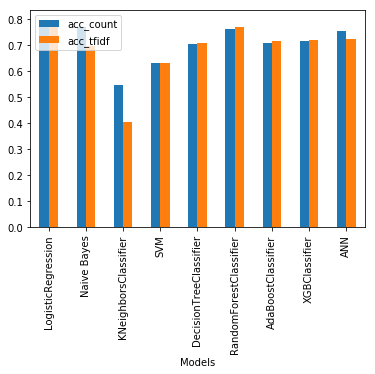

In [39]:
zippedList =  list(zip(models, acc_count, acc_tfidf))
# Create a dataframe from zipped list
df_model = pd.DataFrame(zippedList, columns = ['Models' , 'acc_count', 'acc_tfidf']) 
#plot
df_model.plot(x="Models", y=["acc_count","acc_tfidf"], kind="bar")

### deep learning configuration

In [40]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today() 

In [41]:
main_model_dir = r"model/"
main_log_dir = r"log/"
try:
    os.mkdir(main_model_dir)
except:
    print("Could not create main model directory")
try:
    os.mkdir(main_log_dir)
except:
    print("Could not create main log directory")

model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')
try:
    os.mkdir(model_dir)
except:
    print("Could not create model directory")
try:
    os.mkdir(log_dir)
except:
    print("Could not create log directory")
    
model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

Could not create main model directory
Could not create main log directory


In [42]:
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=9,
    verbose=1,
    restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1)

callbacks = [checkpoint, reduce_lr, early_stopping]

print("Set Callbacks at ", date_time(1))

('Set Callbacks at ', 'Timestamp: 2019-06-08 20:37:40')


### data transformation for deep learning

In [43]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_test

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [44]:
max_words = len(set(" ".join(x_train).split()))
max_len = x_train.apply(lambda x: len(x)).max()

# max_words = 1000
# max_len = 150
max_words, max_len

(9799, 131)

In [45]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_seq = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_seq = sequence.pad_sequences(x_test_seq, maxlen=max_len)
x_test_seq.shape

(2928, 131)

### model plotting

In [46]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Test']

    plt.figure(figsize=(20, 5))

    y1 = history.history['acc']
    y2 = history.history['val_acc']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]

    plt.subplot(122)
    plt.plot(y1)
    plt.plot(y2)
    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    #plt.savefig("/history")
    plt.show()

### LSTM

In [47]:
def get_rnn_model(num_class=3):
    model = Sequential()
    
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(LSTM(256))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    if num_class>2:
        model.add(Dense(num_class, activation='softmax'))
    else:
        model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    
    return model

In [48]:
num_class = 3
model1 = get_rnn_model(num_class=num_class)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 131, 100)          979900    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
__________

In [49]:
%%time
print("Starting...\n")

start_time = time.time()
print(date_time(1))

learning_rate = 0.001
optimizer = Adam(learning_rate)
# optimizer = Adam()
loss = 'categorical_crossentropy'
# loss = 'binary_crossentropy'
metrics = ['accuracy']

verbose = 1
epochs = 100
batch_size = 128
validation_split = 0.2

model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history1 = model1.fit(
    x_train_seq,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_split=validation_split)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print(date_time(1))

Starting...

Timestamp: 2019-06-08 20:37:52
Train on 9369 samples, validate on 2343 samples
Epoch 1/100
9369/9369 [==============================] - 61s 6ms/step - loss: 1.4880 - acc: 0.4880 - val_loss: 1.0879 - val_acc: 0.6449
Epoch 2/100
9369/9369 [==============================] - 59s 6ms/step - loss: 0.8940 - acc: 0.6475 - val_loss: 0.9134 - val_acc: 0.6957
Epoch 3/100
9369/9369 [==============================] - 57s 6ms/step - loss: 0.5666 - acc: 0.7784 - val_loss: 0.7072 - val_acc: 0.7461
Epoch 4/100
9369/9369 [==============================] - 62s 7ms/step - loss: 0.4123 - acc: 0.8428 - val_loss: 0.7017 - val_acc: 0.7546
Epoch 5/100
9369/9369 [==============================] - 55s 6ms/step - loss: 0.3042 - acc: 0.8874 - val_loss: 0.7671 - val_acc: 0.7542

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.000500000023749.
Epoch 6/100
9369/9369 [==============================] - 57s 6ms/step - loss: 0.2254 - acc: 0.9193 - val_loss: 0.7986 - val_acc: 0.7512

Epoch 00006: R

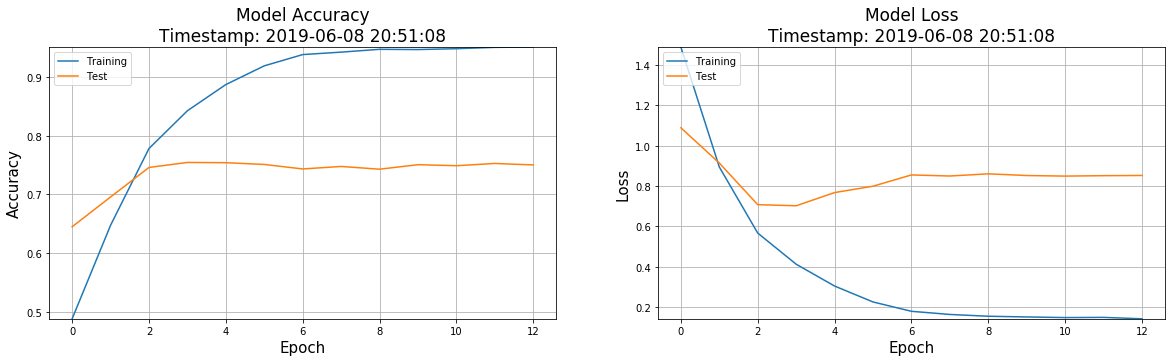

In [50]:
plot_performance(history=history1)

### CNN

In [51]:
def get_cnn_model(num_class=3):   
    model = Sequential()
    
    model.add(Embedding(max_words, 100, input_length=max_len))
    
    model.add(Conv1D(1024, 3, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())
    
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(2048, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    if num_class>2:
        model.add(Dense(num_class, activation='softmax'))
    else:
        model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    return model

In [52]:
num_class = 3
model2 = get_cnn_model(num_class=num_class)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 131, 100)          979900    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 129, 1024)         308224    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              2099200   
__________

In [53]:
%%time
print("Starting...\n")

start_time = time.time()
print(date_time(1))

learning_rate = 0.001
optimizer = Adam(learning_rate)
# optimizer = Adam()
loss = 'categorical_crossentropy'
# loss = 'binary_crossentropy'
metrics = ['accuracy']

model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

verbose = 1
epochs = 100
batch_size = 128
validation_split = 0.2

history2 = model2.fit(
    x_train_seq,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_split=validation_split)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed...", date_time(1))

Starting...

Timestamp: 2019-06-08 20:51:16
Train on 9369 samples, validate on 2343 samples
Epoch 1/100
9369/9369 [==============================] - 65s 7ms/step - loss: 1.4441 - acc: 0.5255 - val_loss: 0.7600 - val_acc: 0.7072
Epoch 2/100
9369/9369 [==============================] - 62s 7ms/step - loss: 0.8900 - acc: 0.6736 - val_loss: 0.6577 - val_acc: 0.7584
Epoch 3/100
9369/9369 [==============================] - 65s 7ms/step - loss: 0.6138 - acc: 0.7651 - val_loss: 0.6072 - val_acc: 0.7734
Epoch 4/100
9369/9369 [==============================] - 66s 7ms/step - loss: 0.4593 - acc: 0.8251 - val_loss: 0.6496 - val_acc: 0.7687

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.000500000023749.
Epoch 5/100
9369/9369 [==============================] - 65s 7ms/step - loss: 0.3345 - acc: 0.8735 - val_loss: 0.6581 - val_acc: 0.7768

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.000250000011874.
Epoch 6/100
9369/9369 [==============================] - 66s 7ms/step - lo

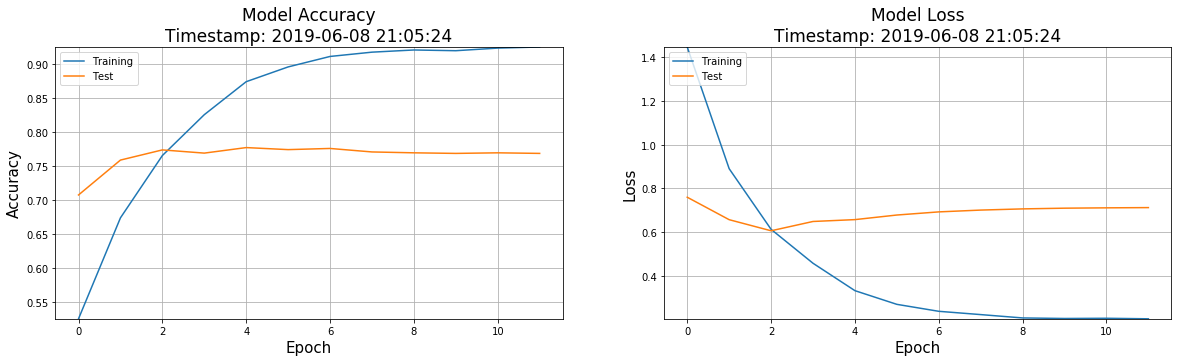

In [54]:
plot_performance(history=history2)

### Inference/ Prediction

In [55]:
accuracy1 = model1.evaluate(x_test_seq, y_test)
accuracy2 = model2.evaluate(x_test_seq, y_test)

2928/2928 [==============================] - 3s 1ms/step


In [56]:
print("Model Performance of RNN (Test Accuracy):")
print('Accuracy: {:0.2f}%\nLoss: {:0.3f}\n'.format(accuracy1[1]*100, accuracy1[0]))

print("\nModel Performance of RNN (Test Accuracy):")
print('v: {:0.2f}%\nLoss: {:0.3f}\n'.format(accuracy2[1]*100, accuracy2[0]))

Model Performance of RNN (Test Accuracy):
Accuracy: 76.20%
Loss: 0.692


Model Performance of RNN (Test Accuracy):
v: 77.46%
Loss: 0.587



In [57]:
pred_lstm = model1.predict_classes(x_test_seq, verbose=1)
pred_cnn = model2.predict_classes(x_test_seq, verbose=1)

2928/2928 [==============================] - 4s 1ms/step


In [58]:
# LSTM
y_test_int = [np.argmax(i) for i in y_test]
cm = confusion_matrix(y_test_int, pred_lstm)
acc_lr = accuracy_score(y_test_int, pred_lstm)
acc_tfidf.append(acc_lr)
models.append("LSTM")
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test_int, pred_lstm))

('accuracy: ', 0.7619535519125683)
[[1504  284   57]
 [ 123  429   57]
 [  65  111  298]]
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1845
           1       0.52      0.70      0.60       609
           2       0.72      0.63      0.67       474

   micro avg       0.76      0.76      0.76      2928
   macro avg       0.71      0.72      0.71      2928
weighted avg       0.79      0.76      0.77      2928



In [59]:
# CNN
y_test_int = [np.argmax(i) for i in y_test]
cm = confusion_matrix(y_test_int, pred_cnn)
acc_lr = accuracy_score(y_test_int, pred_cnn)
acc_tfidf.append(acc_lr)
models.append("CNN")
print("accuracy: ", acc_lr)
print(cm)
print(classification_report(y_test_int, pred_cnn))

('accuracy: ', 0.7745901639344263)
[[1633  170   42]
 [ 208  326   75]
 [ 101   64  309]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1845
           1       0.58      0.54      0.56       609
           2       0.73      0.65      0.69       474

   micro avg       0.77      0.77      0.77      2928
   macro avg       0.72      0.69      0.70      2928
weighted avg       0.77      0.77      0.77      2928



### Comparison with Machine Learning

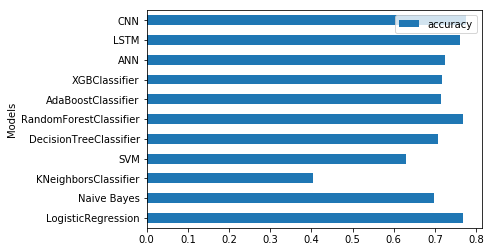

In [61]:
zippedList =  list(zip(models, acc_tfidf))
# Create a dataframe from zipped list
df_model = pd.DataFrame(zippedList, columns = ['Models' , 'accuracy']) 
#plot
df_model.plot(x="Models", y=["accuracy"], kind="barh")

In [62]:
df_model

,Models,accuracy
0,LogisticRegression,0.768443
1,Naive Bayes,0.697746
2,KNeighborsClassifier,0.403005
3,SVM,0.630123
4,DecisionTreeClassifier,0.706626
5,RandomForestClassifier,0.767760
6,AdaBoostClassifier,0.714481
7,XGBClassifier,0.718238
8,ANN,0.724044
9,LSTM,0.761954
